<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/ppg_ecg_bp_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
# =========================================================
# 라이브러리
# =========================================================
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import mean_absolute_error
import pandas as pd

# =========================================================
# 1) 데이터 로딩 함수
# =========================================================
def load_signals_from_mat(mat_path, num_samples=None):
    """
    MATLAB .mat 파일에서 PPG, ABP, ECG, SBP, DBP 로드
    """
    signals = {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}
    with h5py.File(mat_path, 'r') as f:
        ppg_refs = f['Subj_Wins']['PPG_Raw'][0]
        abp_refs = f['Subj_Wins']['ABP_Raw'][0] if 'ABP_Raw' in f['Subj_Wins'] else None
        ecg_refs = f['Subj_Wins']['ECG_Raw'][0] if 'ECG_Raw' in f['Subj_Wins'] else None
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        total = len(ppg_refs) if num_samples is None else min(len(ppg_refs), num_samples)
        for i in range(total):
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            signals['ppg'].append(ppg)
            if abp_refs is not None:
                abp = f[abp_refs[i]][()].squeeze().astype(np.float32)
                signals['abp'].append(abp)
            if ecg_refs is not None:
                ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
                signals['ecg'].append(ecg)
            sbp = float(f[sbp_refs[i]][()].squeeze())
            dbp = float(f[dbp_refs[i]][()].squeeze())
            signals['sbp'].append(sbp)
            signals['dbp'].append(dbp)
    return signals

# =========================================================
# 2) 간단 시각화 함수
# =========================================================
def plot_signals(signals, sample_idx=0, fs=125):
    num_plots = 1
    if signals['abp']: num_plots += 1
    if signals['ecg']: num_plots += 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3*num_plots))
    if num_plots == 1: axes = [axes]

    plot_idx = 0
    ppg = signals['ppg'][sample_idx]
    t = np.arange(len(ppg)) / fs
    axes[plot_idx].plot(t, ppg, 'b-')
    axes[plot_idx].set_title("PPG")
    plot_idx += 1

    if signals['abp']:
        abp = signals['abp'][sample_idx]
        t = np.arange(len(abp)) / fs
        axes[plot_idx].plot(t, abp, 'r-')
        axes[plot_idx].set_title(f"ABP (SBP={signals['sbp'][sample_idx]}, DBP={signals['dbp'][sample_idx]})")
        plot_idx += 1

    if signals['ecg']:
        ecg = signals['ecg'][sample_idx]
        t = np.arange(len(ecg)) / fs
        axes[plot_idx].plot(t, ecg, 'g-')
        axes[plot_idx].set_title("ECG")
    plt.tight_layout()
    plt.show()

# ========================
# 다중 샘플 비교 시각화
# ========================
def plot_multiple_samples(signals, num_samples=3, signal_type='ppg', fs=125):
    """
    여러 샘플의 동일 신호(ppg/abp/ecg)를 비교
    """
    fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))
    if num_samples == 1: axes = [axes]

    signal_data = signals[signal_type]
    colors = ['blue', 'red', 'green']

    for i in range(min(num_samples, len(signal_data))):
        sig = signal_data[i]
        t = np.arange(len(sig)) / fs
        axes[i].plot(t, sig, color=colors[i % len(colors)], linewidth=1.2)
        title = f"{signal_type.upper()} Signal - Sample {i}"
        if signal_type == 'ppg' and signals['sbp']:
            title += f" (SBP={signals['sbp'][i]:.1f}, DBP={signals['dbp'][i]:.1f})"
        axes[i].set_title(title)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Amplitude")
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()




In [115]:

# =========================================================
# 3) 4-fold 분할
# =========================================================
def sequential_four_fold_indices(N, train_size=300, test_size=100):
  fold_size = N // 4   # 1600/4 = 400
  indices = []
  for k in range(4):
      start = k * fold_size
      end = start + fold_size
      fold_idx = np.arange(start, end)
      train_idx = fold_idx[:train_size]
      test_idx = fold_idx[train_size:train_size+test_size]
      indices.append((train_idx, test_idx))
  return indices


# =========================================================
# 4) 모델 정의 (CNN, BiLSTM, Transformer, Hybrid)
# =========================================================
def build_cnn(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='linear')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model

def build_cnn_bilstm(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='linear')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = transformer_encoder(inputs, head_size=32, num_heads=4, ff_dim=128, dropout=0.2)
    x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=128, dropout=0.2)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation="linear")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mae")
    return model

def build_hybrid(input_len, n_channels):
    inputs = layers.Input(shape=(input_len, n_channels))
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=128, dropout=0.2)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation="linear")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mae")
    return model

# =========================================================
# 5) 학습/평가 루프
# =========================================================
def zscore_fit_apply(x, tr_idx, te_idx):
    x_tr, x_te = x[tr_idx].copy(), x[te_idx].copy()
    mean = x_tr.mean(axis=(0,1), keepdims=True)
    std  = x_tr.std(axis=(0,1), keepdims=True) + 1e-8
    return (x_tr-mean)/std, (x_te-mean)/std

def train_eval_4fold(x_all, y_all, indices, build_fn, model_name="Model"):
    rows = []
    for k,(tr,te) in enumerate(indices,1):
        if len(tr)==0 or len(te)==0:
            rows.append({"Model":model_name,"Fold":k,"SBP_MAE":np.nan,"DBP_MAE":np.nan})
            continue
        x_tr,x_te = zscore_fit_apply(x_all,tr,te)
        y_tr,y_te = y_all[tr], y_all[te]
        model = build_fn(x_tr.shape[1], x_tr.shape[2])
        es = callbacks.EarlyStopping(patience=10,restore_best_weights=True)
        model.fit(x_tr,y_tr,validation_split=0.1,shuffle=False,
                  epochs=50,batch_size=32,verbose=0,callbacks=[es])
        pred = model.predict(x_te,verbose=0)
        sbp_mae = mean_absolute_error(y_te[:,0],pred[:,0])
        dbp_mae = mean_absolute_error(y_te[:,1],pred[:,1])
        print(f"[{model_name}] Fold{k}: SBP_MAE={sbp_mae:.2f}, DBP_MAE={dbp_mae:.2f}")
        rows.append({"Model":model_name,"Fold":k,"SBP_MAE":sbp_mae,"DBP_MAE":dbp_mae})
    return pd.DataFrame(rows)

def train_and_evaluate(model_fn, x, y, indices, model_name="Model"):
    results = []
    for fold, (tr_idx, te_idx) in enumerate(indices, 1):

        # train/test split
        x_tr, y_tr = x[tr_idx], y[tr_idx]
        x_te, y_te = x[te_idx], y[te_idx]

        # validation split (train의 마지막 10%)
        val_size = int(0.1 * len(x_tr))
        x_val, y_val = x_tr[-val_size:], y_tr[-val_size:]
        x_tr, y_tr = x_tr[:-val_size], y_tr[:-val_size]

        # z-score normalization (train 기준)
        mean, std = x_tr.mean(axis=(0,1), keepdims=True), x_tr.std(axis=(0,1), keepdims=True)
        x_tr = (x_tr - mean) / (std + 1e-6)
        x_val = (x_val - mean) / (std + 1e-6)
        x_te  = (x_te  - mean) / (std + 1e-6)

        # 모델 빌드
        model = model_fn(x.shape[1], x.shape[2])
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='mae')

        # 콜백
        es   = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
        rlrp = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor='val_loss')

        # 학습
        model.fit(x_tr, y_tr,
                  validation_data=(x_val, y_val),
                  epochs=80, batch_size=32,
                  shuffle=False, callbacks=[es, rlrp], verbose=0)

        # 평가
        y_pred = model.predict(x_te, verbose=0)
        sbp_mae = mean_absolute_error(y_te[:,0], y_pred[:,0])
        dbp_mae = mean_absolute_error(y_te[:,1], y_pred[:,1])

        print(f"[{model_name}] Fold{fold}: SBP_MAE={sbp_mae:.2f}, DBP_MAE={dbp_mae:.2f}")
        results.append({"Model": model_name, "Fold": fold,
                        "SBP_MAE": sbp_mae, "DBP_MAE": dbp_mae})

    return pd.DataFrame(results)


# def compare_models(x_all, y_all, indices):
#     models_to_test = {
#         # "CNN": build_cnn,
#         # "CNN+BiLSTM": build_cnn_bilstm,
#         # "Transformer": build_transformer,
#         "Hybrid": build_hybrid,
#     }
#     all_results = []
#     for name, fn in models_to_test.items():
#         df = train_and_evaluate(fn, x_all, y_all, indices, model_name=name)
#         all_results.append(df)
#     results = pd.concat(all_results, ignore_index=True)
#     summary = results.groupby("Model")[["SBP_MAE","DBP_MAE"]].mean().reset_index()
#     print("\n=== Summary (4-Fold 평균 MAE) ===")
#     print(summary)
#     return results, summary

def compare_models(x_all, y_all, indices):
  models_to_test = {
      # "CNN": build_cnn,
      # "CNN+BiLSTM": build_cnn_bilstm,
      # "Transformer": build_transformer,
      "Hybrid": build_hybrid,
  }
  all_results = []
  for name, fn in models_to_test.items():
      df = train_and_evaluate(fn, x_all, y_all, indices, model_name=name)
      all_results.append(df)

  results = pd.concat(all_results, ignore_index=True)

  # 평균과 표준편차 같이 계산
  summary = results.groupby("Model").agg(
      SBP_mean=("SBP_MAE", "mean"),
      SBP_std=("SBP_MAE", "std"),
      DBP_mean=("DBP_MAE", "mean"),
      DBP_std=("DBP_MAE", "std")
  ).reset_index()

  # 평균 + 표준편차
  summary["SBP_mean+std"] = summary["SBP_mean"] + summary["SBP_std"]
  summary["DBP_mean+std"] = summary["DBP_mean"] + summary["DBP_std"]

  print("\n=== Summary (4-Fold MAE: mean ± std) ===")
  print(summary)

  return results, summary



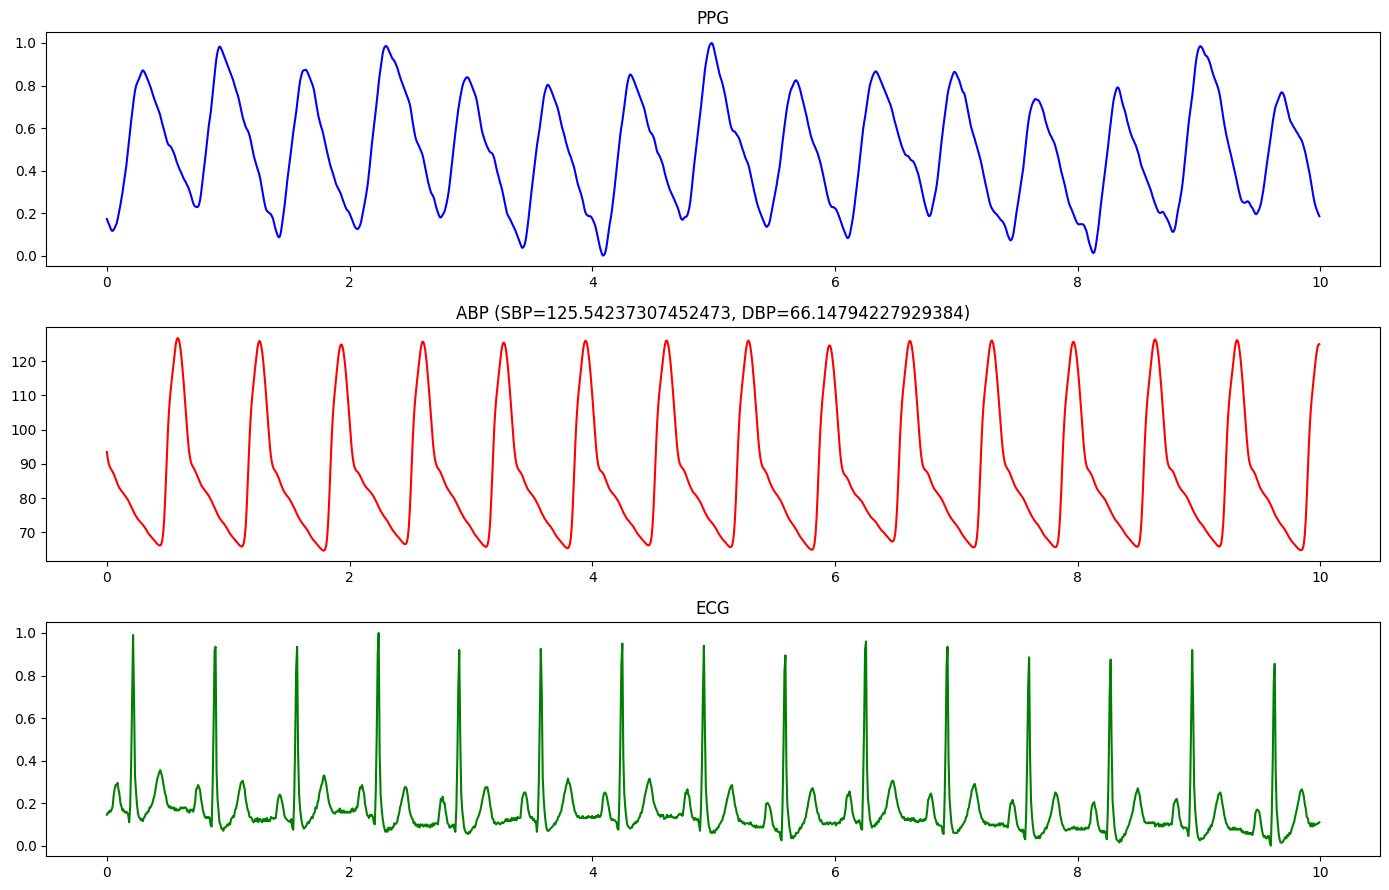

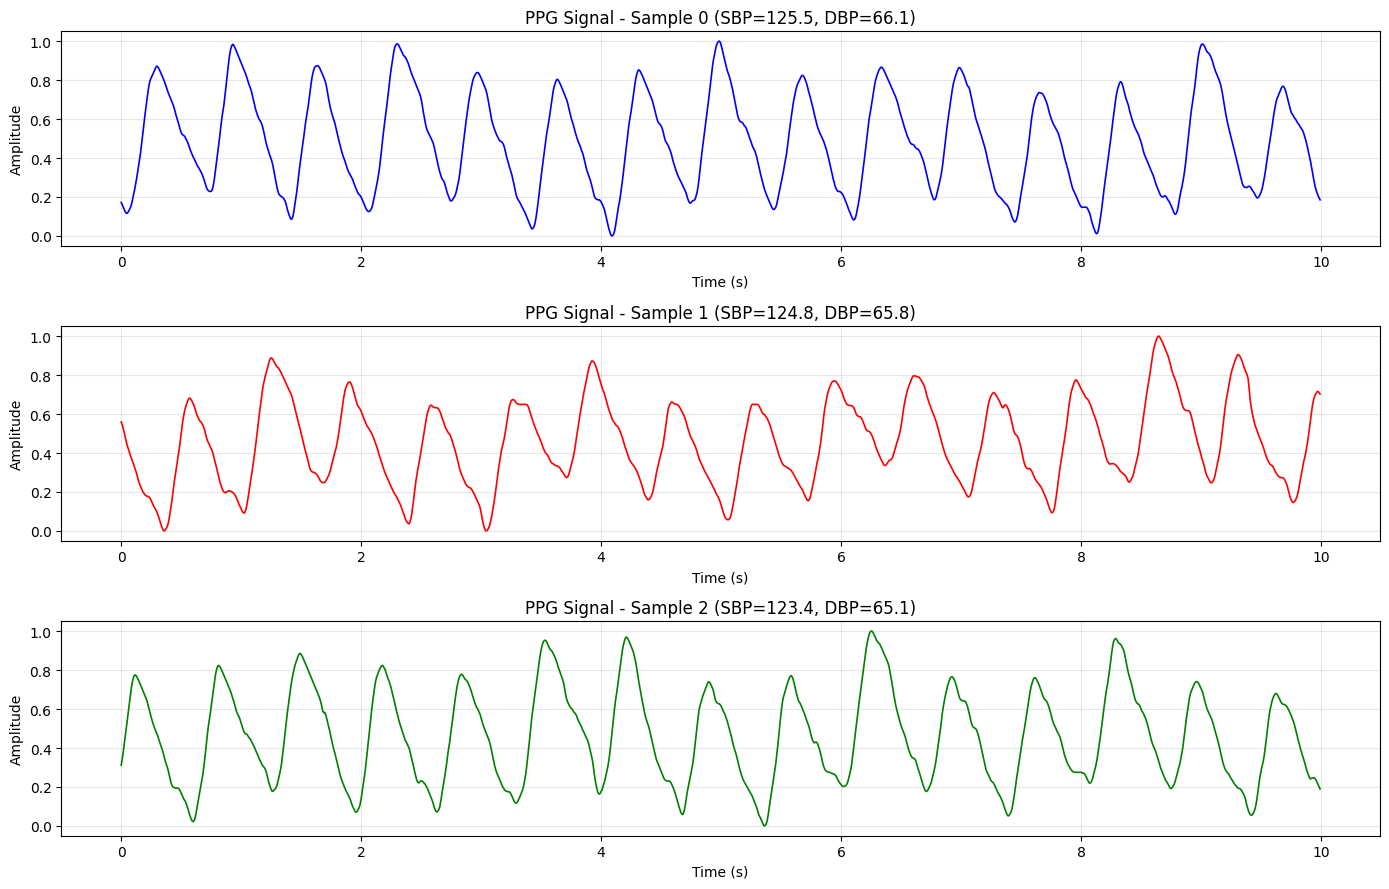

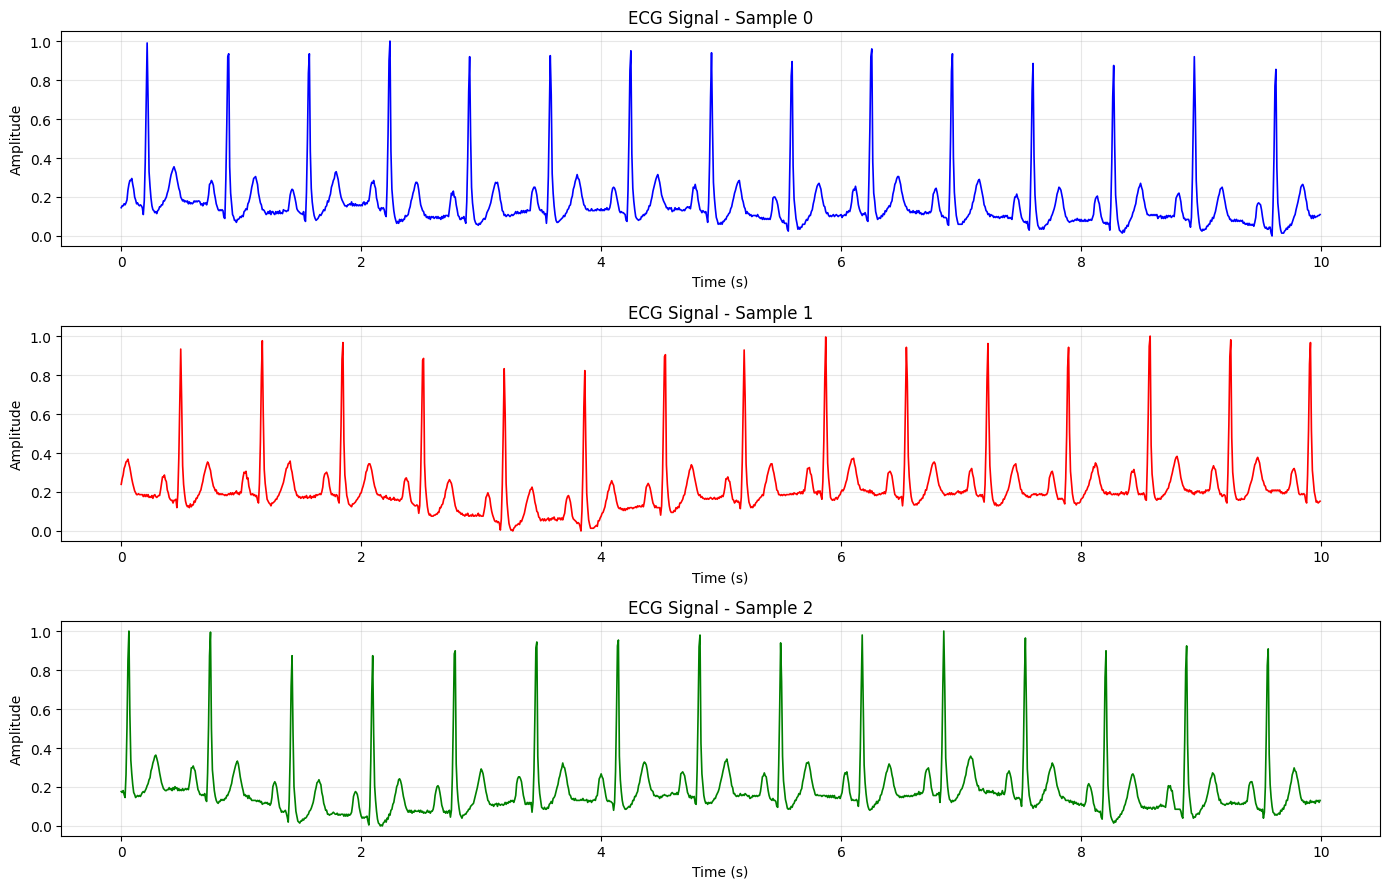

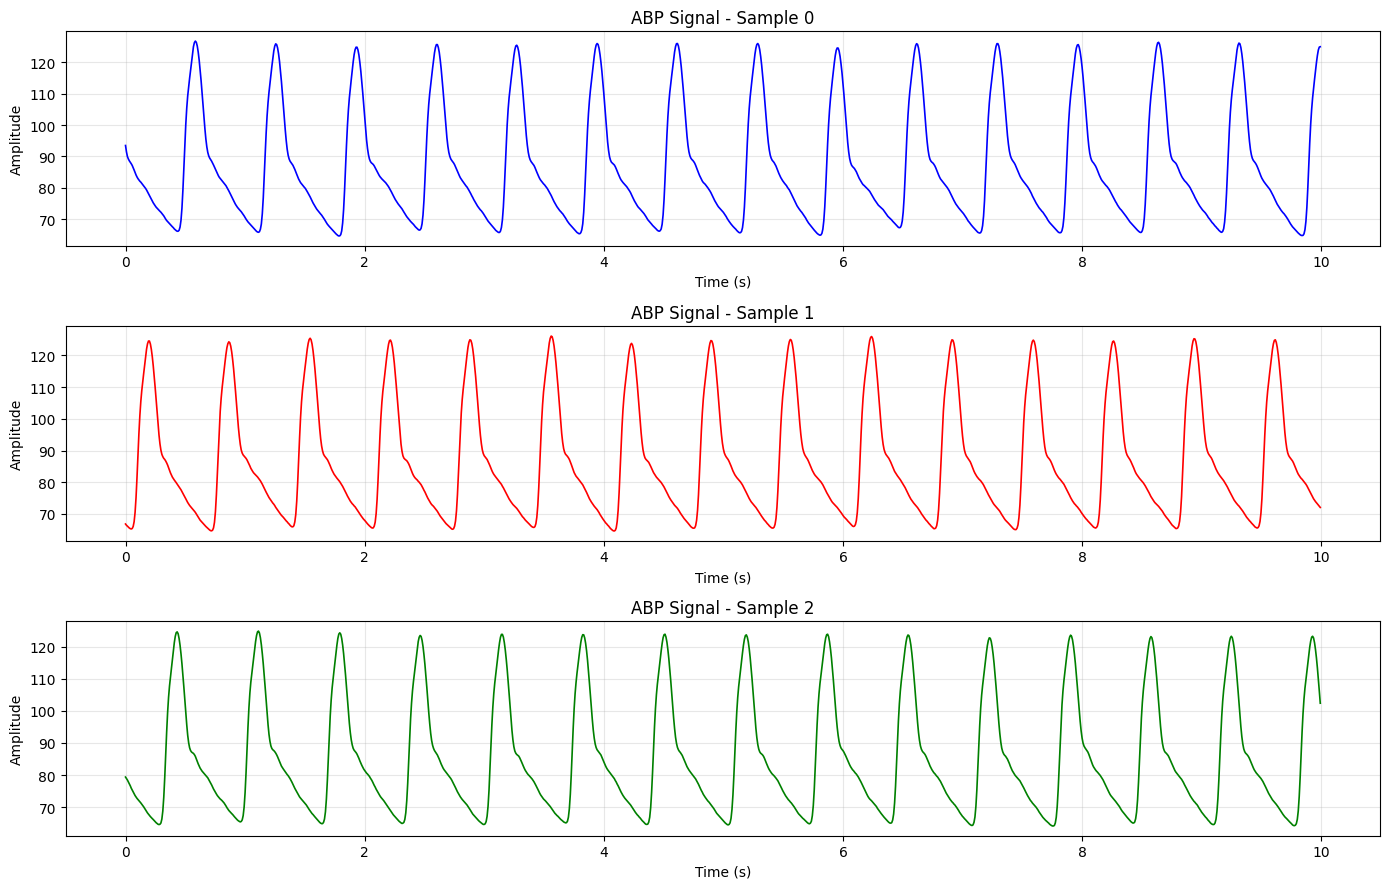

In [112]:

# =========================================================
# 6) 실행 예제
# =========================================================
if __name__ == "__main__":
    mat_path = "/content/drive/MyDrive/ML_Class/p044036.mat"  # 경로 수정
    signals = load_signals_from_mat(mat_path, num_samples=None)



    # 1) 단일 샘플 시각화
    plot_signals(signals, sample_idx=0, fs=125)

    # 2) 여러 샘플 비교 (PPG 3개)
    plot_multiple_samples(signals, num_samples=3, signal_type='ppg', fs=125)

    # 3) 여러 샘플 비교 (ECG 3개)
    plot_multiple_samples(signals, num_samples=3, signal_type='ecg', fs=125)

    # 4) 여러 샘플 비교 (ABP 3개)
    plot_multiple_samples(signals, num_samples=3, signal_type='abp', fs=125)



In [113]:
    # X, y 준비# signals 로드 후
    max_samples = 1600
    for k in signals:
      signals[k] = signals[k][:max_samples]

    y = np.stack([signals['sbp'], signals['dbp']], axis=-1).astype(np.float32)
    N = len(signals['ppg'])   # 이제 항상 1600
    L = len(signals['ppg'][0])

    x_ppg = np.stack(signals['ppg']).reshape(N, L, 1)
    x_mix = np.stack([signals['ppg'], signals['ecg']], axis=-1) if signals['ecg'] else x_ppg


    # 4-fold 분할
    indices = sequential_four_fold_indices(N)

In [116]:
# PPG+ECG 비교
results_mix, summary_mix = compare_models(x_mix, y, indices)

[Hybrid] Fold1: SBP_MAE=3.26, DBP_MAE=0.78
[Hybrid] Fold2: SBP_MAE=7.48, DBP_MAE=3.68
[Hybrid] Fold3: SBP_MAE=1.44, DBP_MAE=0.90
[Hybrid] Fold4: SBP_MAE=2.66, DBP_MAE=1.36

=== Summary (4-Fold MAE: mean ± std) ===
    Model  SBP_mean   SBP_std  DBP_mean   DBP_std  SBP_mean+std  DBP_mean+std
0  Hybrid  3.711289  2.623785  1.678859  1.357739      6.335074      3.036598


In [117]:
# PPG-only 비교
results_ppg, summary_ppg = compare_models(x_ppg, y, indices)

[Hybrid] Fold1: SBP_MAE=2.69, DBP_MAE=0.62
[Hybrid] Fold2: SBP_MAE=7.69, DBP_MAE=5.35
[Hybrid] Fold3: SBP_MAE=1.45, DBP_MAE=1.87
[Hybrid] Fold4: SBP_MAE=2.93, DBP_MAE=1.29

=== Summary (4-Fold MAE: mean ± std) ===
    Model  SBP_mean   SBP_std  DBP_mean  DBP_std  SBP_mean+std  DBP_mean+std
0  Hybrid  3.690785  2.746138  2.283545  2.10918      6.436923      4.392725
